In [2]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import Model, Sequential

from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

# 13. 데이터윈도잉/베이스라인모델

In [4]:
train_df = pd.read_csv('/content/drive/MyDrive/BK21/수정/시계열 실습/data/traffic_train_df.csv', index_col=0)
val_df = pd.read_csv('/content/drive/MyDrive/BK21/수정/시계열 실습/data/traffic_val_df.csv', index_col=0)
test_df = pd.read_csv('/content/drive/MyDrive/BK21/수정/시계열 실습/data/traffic_test_df.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


### 13.1.2 DataWindow 클래스 구현하기


In [5]:
class DataWindow():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch

        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )

        ds = ds.map(self.split_to_inputs_labels)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

### 13.2.1 단일 단계 베이스라인 모델


In [6]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['traffic_volume'])

In [7]:
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['traffic_volume'])

In [8]:
# 베이스라인 - 입력 데이터를 예측으로 반환하는 클래스
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs

        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)

        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

In [9]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

baseline_last = Baseline(label_index=column_indices['traffic_volume'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [10]:
val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0135 - mean_absolute_error: 0.0837


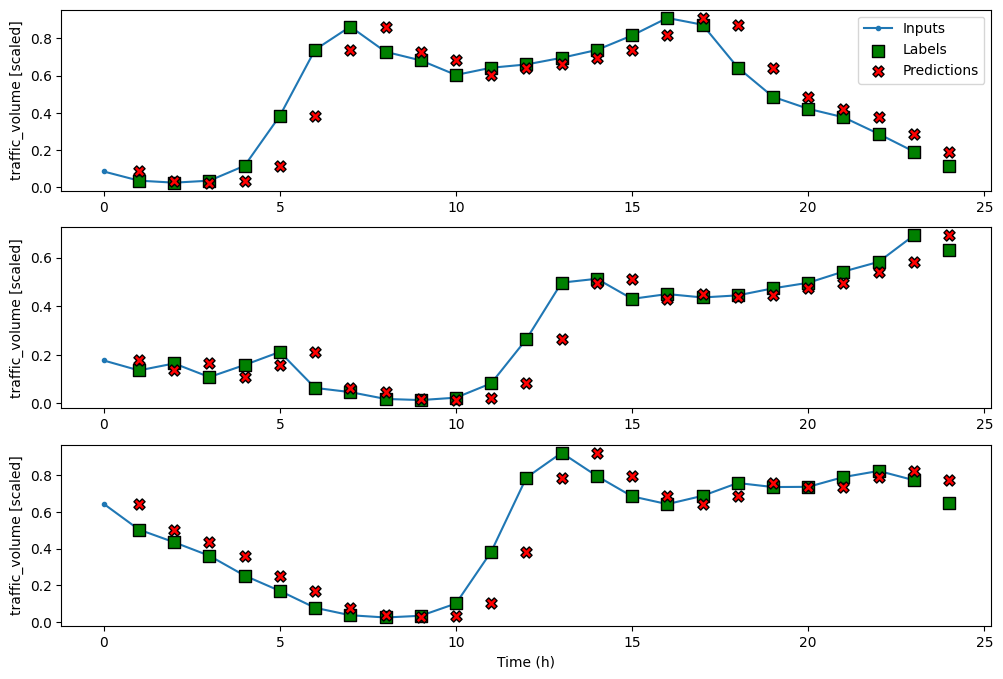

In [11]:
wide_window.plot(baseline_last)

In [12]:
print(performance['Baseline - Last'][1])

0.08128398656845093


### 13.2.2 다중 단계 베이스라인 모델


In [13]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

In [14]:
# 마지막으로 측정된 값으로 예측하기
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

In [15]:
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['traffic_volume'])

ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance = {}
ms_performance = {}

ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)
ms_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1879 - mean_absolute_error: 0.3527


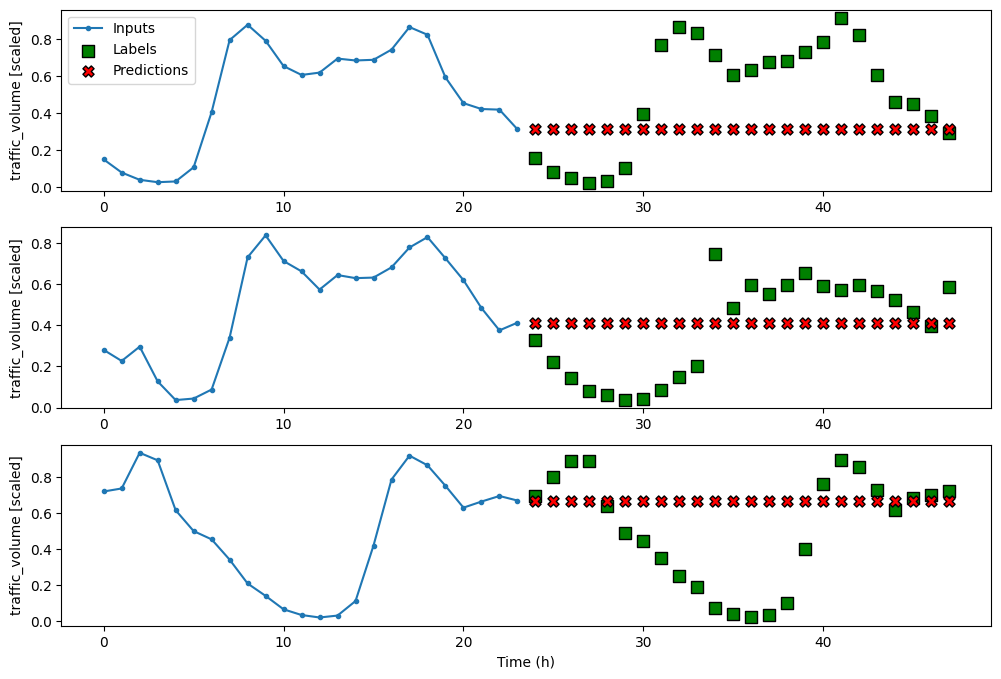

In [16]:
multi_window.plot(ms_baseline_last)

In [17]:
print(ms_performance['Baseline - Last'][1])

0.34706422686576843


In [18]:
# 입력 배열 반복하기
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [19]:
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['traffic_volume'])

ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)
ms_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0)

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2125 - mean_absolute_error: 0.3536


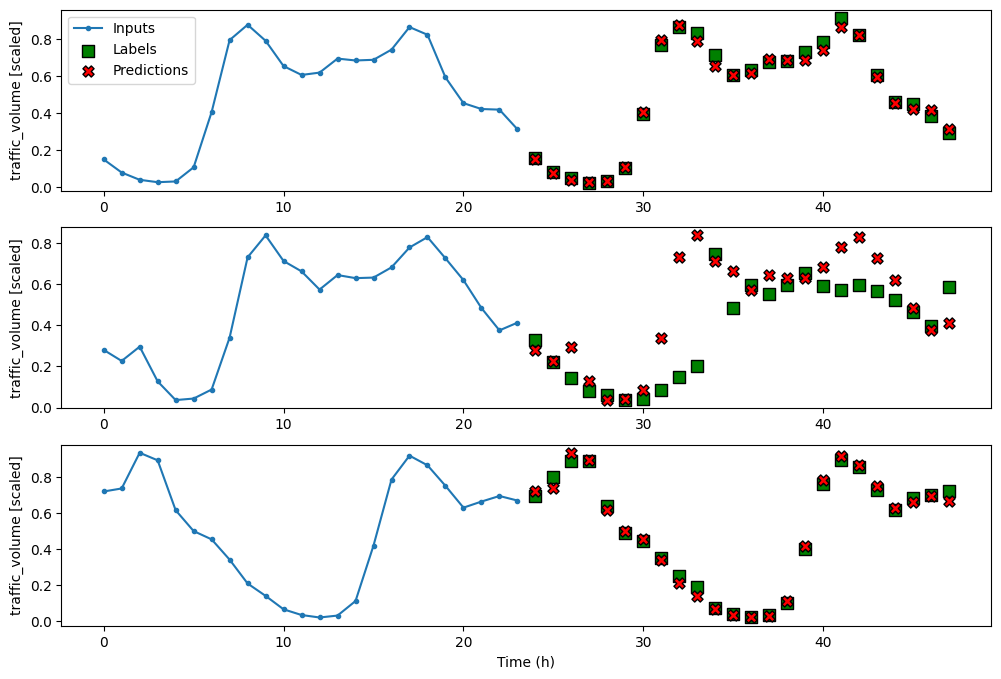

In [20]:
multi_window.plot(ms_baseline_repeat)

In [21]:
print(ms_performance['Baseline - Repeat'][1])

0.343904584646225


### 13.2.3 다중 출력 베이스 모델

In [22]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['temp','traffic_volume'])
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['temp','traffic_volume'])

In [23]:
print(column_indices['traffic_volume'])
print(column_indices['temp'])

2
0


In [24]:
mo_baseline_last = Baseline(label_index=[0, 2]) #단일 단계 모델에서의 BaseLine 재사용

mo_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

mo_val_performance = {}
mo_performance = {}

mo_val_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.val)
mo_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.test, verbose=0)

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0069 - mean_absolute_error: 0.0481


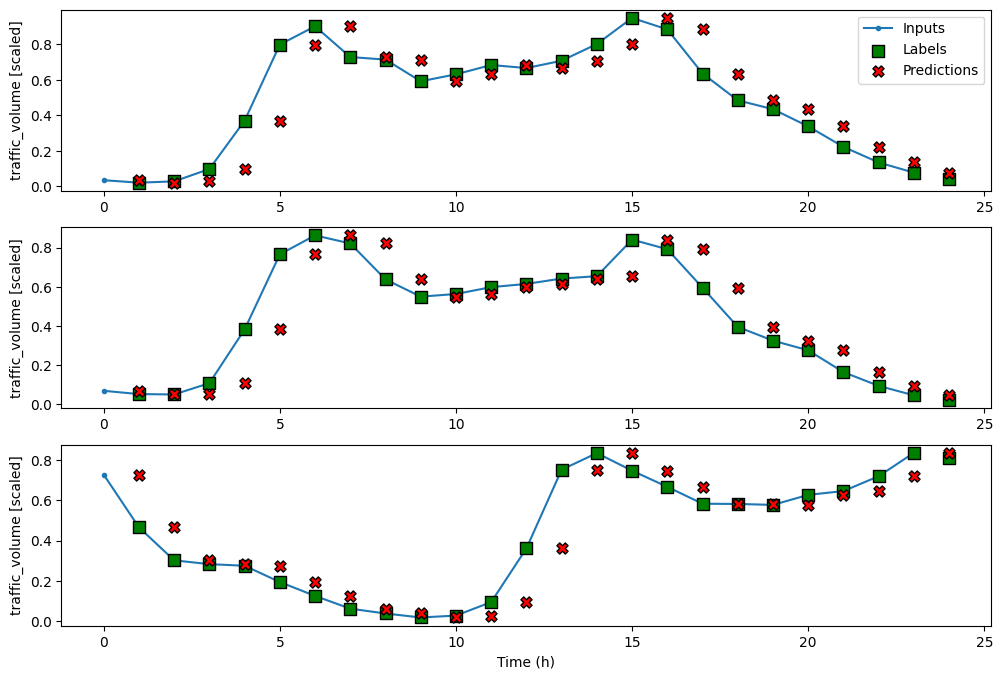

In [25]:
mo_wide_window.plot(mo_baseline_last)

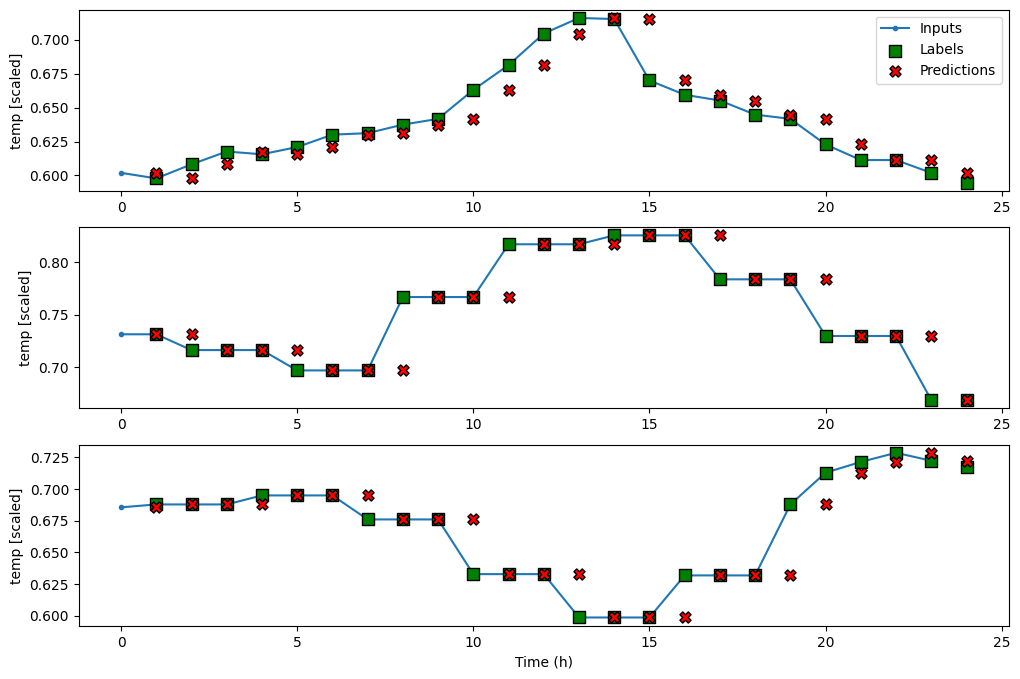

In [26]:
mo_wide_window.plot(model=mo_baseline_last, plot_col='temp')

In [27]:
print(mo_performance['Baseline - Last'][1])

0.04710666462779045


# 14. 딥러닝 첫걸음

## 14.1.1 단일 단계 선형 모델 구현

In [28]:
# 딥러닝 모델 구성하고 데이터에 피팅하는 함수
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')

    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])

    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])

    return history

In [29]:
linear = Sequential([
    Dense(units=1)
])

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0489 - mean_absolute_error: 0.1745 - val_loss: 0.0172 - val_mean_absolute_error: 0.1006
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0137 - mean_absolute_error: 0.0850 - val_loss: 0.0101 - val_mean_absolute_error: 0.0763
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0097 - mean_absolute_error: 0.0697 - val_loss: 0.0093 - val_mean_absolute_error: 0.0720
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0093 - mean_absolute_error: 0.0683 - val_loss: 0.0091 - val_mean_absolute_error: 0.0702
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0093 - mean_absolute_error: 0.0681 - val_loss: 0.0091 - val_mean_absolute_error: 0.0702
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0092 - mean_absolute_error: 0.0681 - val_loss: 0.0090 - val_mean_absolute_error: 0.0696
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0092 - mean_absolute_error: 0.0678 - v

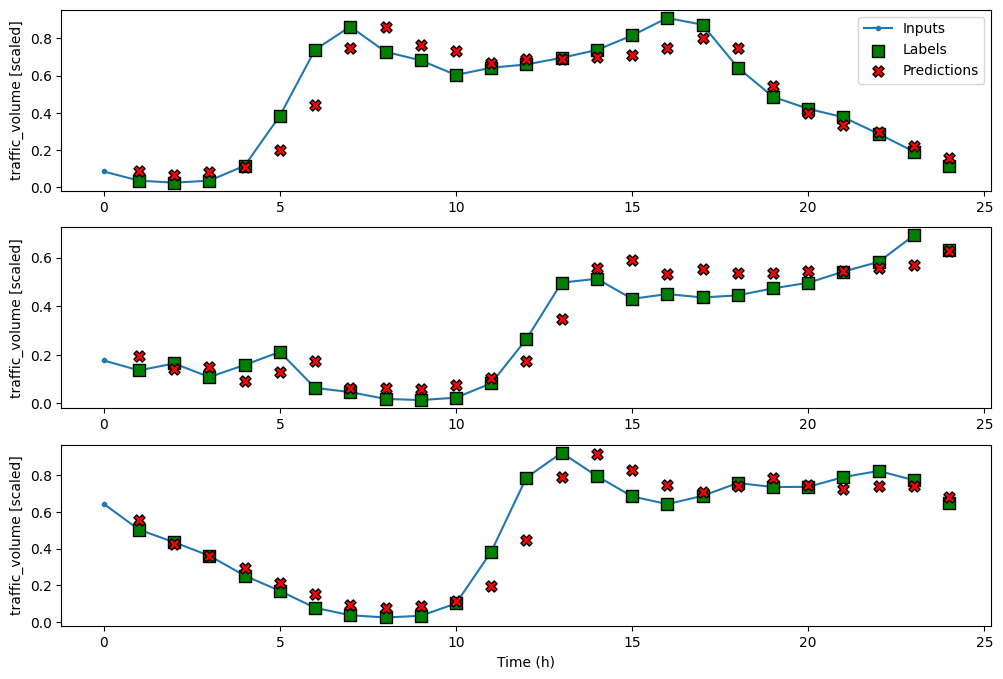

In [30]:
wide_window.plot(linear)

### 14.1.2 다중 단계 선형 모델 구현

In [31]:
ms_linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(ms_linear, multi_window)

ms_val_performance['Linear'] = ms_linear.evaluate(multi_window.val)
ms_performance['Linear'] = ms_linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1432 - mean_absolute_error: 0.3126 - val_loss: 0.0451 - val_mean_absolute_error: 0.1789
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0353 - mean_absolute_error: 0.1550 - val_loss: 0.0249 - val_mean_absolute_error: 0.1231
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0210 - mean_absolute_error: 0.1107 - val_loss: 0.0207 - val_mean_absolute_error: 0.1068
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0179 - mean_absolute_error: 0.0978 - val_loss: 0.0194 - val_mean_absolute_error: 0.1003
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0169 - mean_absolute_error: 0.0922 - val_loss: 0.0187 - val_mean_absolute_error: 0.0958
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0164 - mean_absolute_error: 0.0888 - val_loss: 0.0184 - val_mean_absolute_error: 0.0929
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0161 - mean_absolute_error: 0.0868 - v

### 14.1.2 다중 출력 선형 모델 구현

In [32]:
mo_linear = Sequential([
    Dense(units=2)
])

history = compile_and_fit(mo_linear, mo_single_step_window)

mo_val_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.val)
mo_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.3626 - mean_absolute_error: 0.4336 - val_loss: 0.1524 - val_mean_absolute_error: 0.2842
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1186 - mean_absolute_error: 0.2474 - val_loss: 0.0593 - val_mean_absolute_error: 0.1705
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0456 - mean_absolute_error: 0.1470 - val_loss: 0.0223 - val_mean_absolute_error: 0.1003
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0173 - mean_absolute_error: 0.0862 - val_loss: 0.0097 - val_mean_absolute_error: 0.0620
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0083 - mean_absolute_error: 0.0562 - val_loss: 0.0064 - val_mean_absolute_error: 0.0479
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0061 - mean_absolute_error: 0.0467 - val_loss: 0.0057 - val_mean_absolute_error: 0.0441
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0057 - mean_absolute_error: 0.0441 - v

## 14.2 심층 신경망 구현하기

### 14.2.1 단일 단계 모델로 심층 신경망 구현

In [34]:
dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1)
])


In [35]:
history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0327 - mean_absolute_error: 0.1156 - val_loss: 0.0047 - val_mean_absolute_error: 0.0536
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0043 - mean_absolute_error: 0.0488 - val_loss: 0.0032 - val_mean_absolute_error: 0.0420
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0034 - mean_absolute_error: 0.0425 - val_loss: 0.0025 - val_mean_absolute_error: 0.0371
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0030 - mean_absolute_error: 0.0399 - val_loss: 0.0023 - val_mean_absolute_error: 0.0353
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0028 - mean_absolute_error: 0.0383 - val_loss: 0.0023 - val_mean_absolute_error: 0.0350
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0027 - mean_absolute_error: 0.0373 - val_loss: 0.0021 - val_mean_absolute_error: 0.0338
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0026 - mean_absolute_error: 0.0367 - v

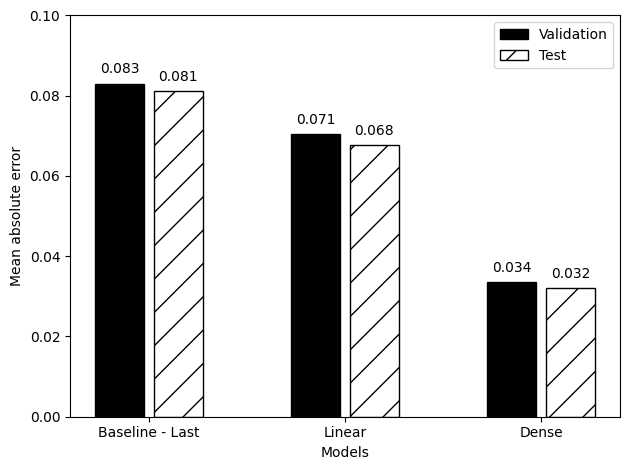

In [36]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

### 14.2.2 다중 단계 모델로 심층 신경망 구현

In [37]:
ms_dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

In [38]:
history = compile_and_fit(ms_dense, multi_window)

ms_val_performance['Dense'] = ms_dense.evaluate(multi_window.val)
ms_performance['Dense'] = ms_dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0673 - mean_absolute_error: 0.1740 - val_loss: 0.0163 - val_mean_absolute_error: 0.0837
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0141 - mean_absolute_error: 0.0781 - val_loss: 0.0150 - val_mean_absolute_error: 0.0815
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0134 - mean_absolute_error: 0.0768 - val_loss: 0.0144 - val_mean_absolute_error: 0.0796
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0130 - mean_absolute_error: 0.0761 - val_loss: 0.0142 - val_mean_absolute_error: 0.0778
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0126 - mean_absolute_error: 0.0749 - val_loss: 0.0137 - val_mean_absolute_error: 0.0780
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0125 - mean_absolute_error: 0.0746 - val_loss: 0.0137 - val_mean_absolute_error: 0.0764
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0124 - mean_absolute_error: 0.0744 - v

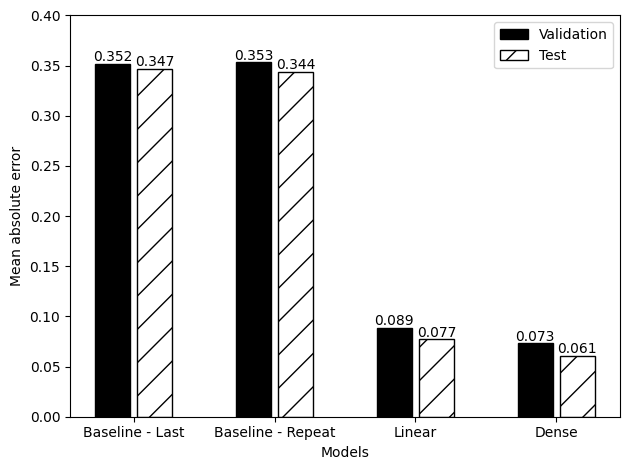

In [39]:
ms_mae_val = [v[1] for v in ms_val_performance.values()]
ms_mae_test = [v[1] for v in ms_performance.values()]

x = np.arange(len(ms_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=ms_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

### 14.2.3 다중 출 모델로 심층 신경망 구현

In [40]:
mo_dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=2)
])

In [41]:
history = compile_and_fit(mo_dense, mo_single_step_window)

mo_val_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.val)
mo_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0399 - mean_absolute_error: 0.1214 - val_loss: 0.0026 - val_mean_absolute_error: 0.0327
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0028 - mean_absolute_error: 0.0328 - val_loss: 0.0018 - val_mean_absolute_error: 0.0288
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0021 - mean_absolute_error: 0.0287 - val_loss: 0.0014 - val_mean_absolute_error: 0.0243
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0019 - mean_absolute_error: 0.0266 - val_loss: 0.0014 - val_mean_absolute_error: 0.0244
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0018 - mean_absolute_error: 0.0259 - val_loss: 0.0014 - val_mean_absolute_error: 0.0243
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0018 - mean_absolute_error: 0.0264 - val_loss: 0.0012 - val_mean_absolute_error: 0.0226
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0018 - mean_absolute_error: 0.0256 - v

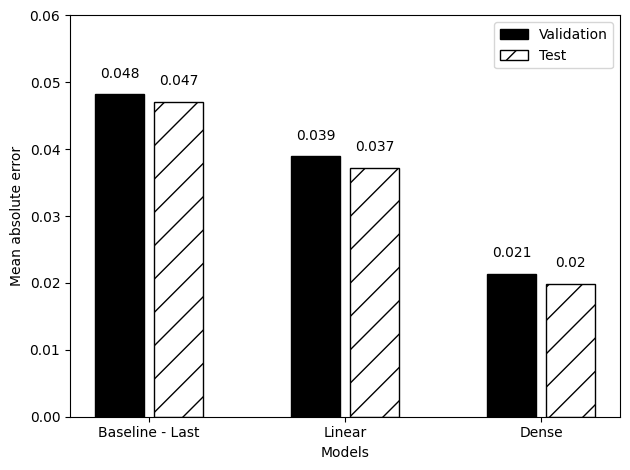

In [42]:
mo_mae_val = [v[1] for v in mo_val_performance.values()]
mo_mae_test = [v[1] for v in mo_performance.values()]

x = np.arange(len(mo_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=mo_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

# 연습

# 13.4 연습


In [69]:
class DataWindow():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='NO2', max_subplots=3):
        inputs, labels = self.sample_batch

        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )

        ds = ds.map(self.split_to_inputs_labels)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

## 1. 단일 단계 모델

In [70]:
train_df = pd.read_csv('/content/drive/MyDrive/BK21/수정/시계열 실습/data/bejing_airquality_train_df.csv', index_col=0)
val_df = pd.read_csv('/content/drive/MyDrive/BK21/수정/시계열 실습/data/bejing_airquality_val_df.csv', index_col=0)
test_df = pd.read_csv('/content/drive/MyDrive/BK21/수정/시계열 실습/data/bejing_airquality_test_df.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)
print(train_df.head())

(13239, 12) (3783, 12) (1892, 12)
      PM2.5      PM10       SO2       NO2        CO   O3      TEMP      PRES  \
0  0.128492  0.146789  0.165192  0.340278  0.191919  0.0  0.212230  0.614679   
1  0.149721  0.179409  0.179941  0.343750  0.202020  0.0  0.194245  0.559633   
2  0.154190  0.216106  0.168142  0.340278  0.222222  0.0  0.176259  0.522936   
3  0.148603  0.158002  0.185841  0.361111  0.292929  0.0  0.176259  0.522936   
4  0.144134  0.163099  0.159292  0.364583  0.292929  0.0  0.194245  0.486239   

       DEWP      WSPM  day_sin   day_cos  
0  0.296721  0.062500  0.25000  0.933013  
1  0.344262  0.062500  0.37059  0.982963  
2  0.318033  0.035714  0.50000  1.000000  
3  0.370492  0.035714  0.62941  0.982963  
4  0.301639  0.098214  0.75000  0.933013  


### a. 마지막으로 측정된 값으로 예측하는 베이스라인 모델 구축

In [71]:
# 베이스라인 - 입력 데이터를 예측으로 반환하는 클래스
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs

        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)

        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

### b. 도식화

In [72]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['NO2'])
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['NO2'])

In [73]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

In [74]:
baseline_last = Baseline(label_index=column_indices['NO2'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [75]:
val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021 - mean_absolute_error: 0.0279


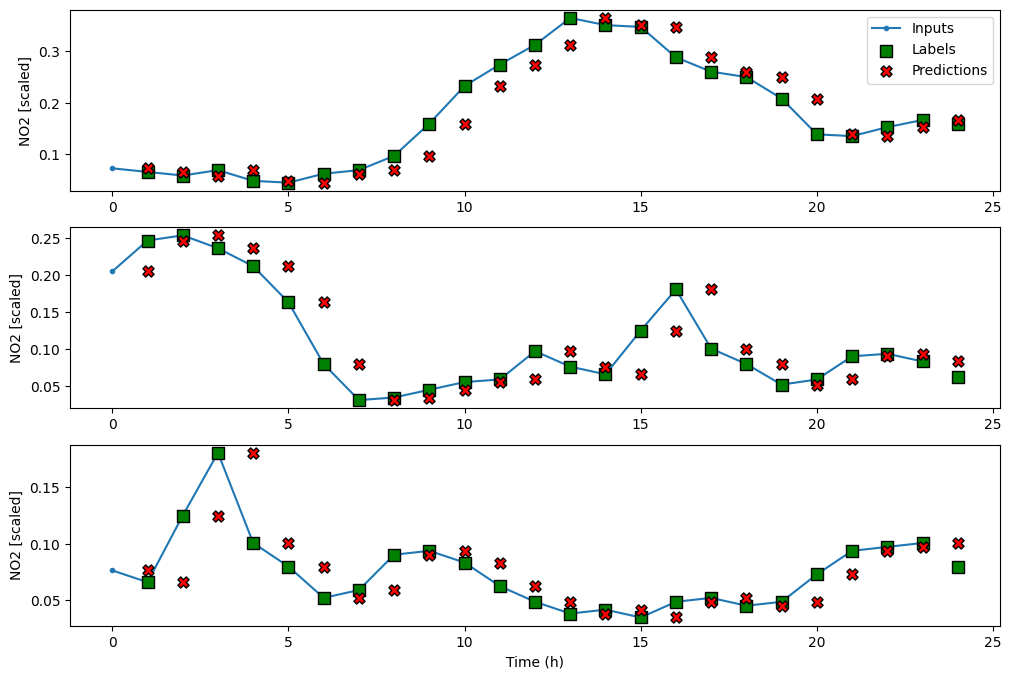

In [76]:
wide_window.plot(baseline_last, plot_col='NO2')

### MAE로 성능 평가 비교 가능하도록 사전에 저장

In [77]:
print(performance['Baseline - Last'][1])
performance_last = performance

0.0333586111664772


## 2. 다중 단계 모델

### a. 24시간 동안 마지막으로 측정된 값으로 예측하는 베이스라인 구축

In [78]:
# 마지막으로 측정된 값으로 예측하기
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

### b. 지난 24시간을 반복하는 베이스라인 모델 구축

In [79]:
# 입력 배열 반복하기
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        return inputs[:, :, self.label_index:]

### c. 두 모델의 예측 도식

In [80]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['NO2'])

In [81]:
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['NO2'])

ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance = {}
ms_performance = {}

ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)
ms_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1429 - mean_absolute_error: 0.2807


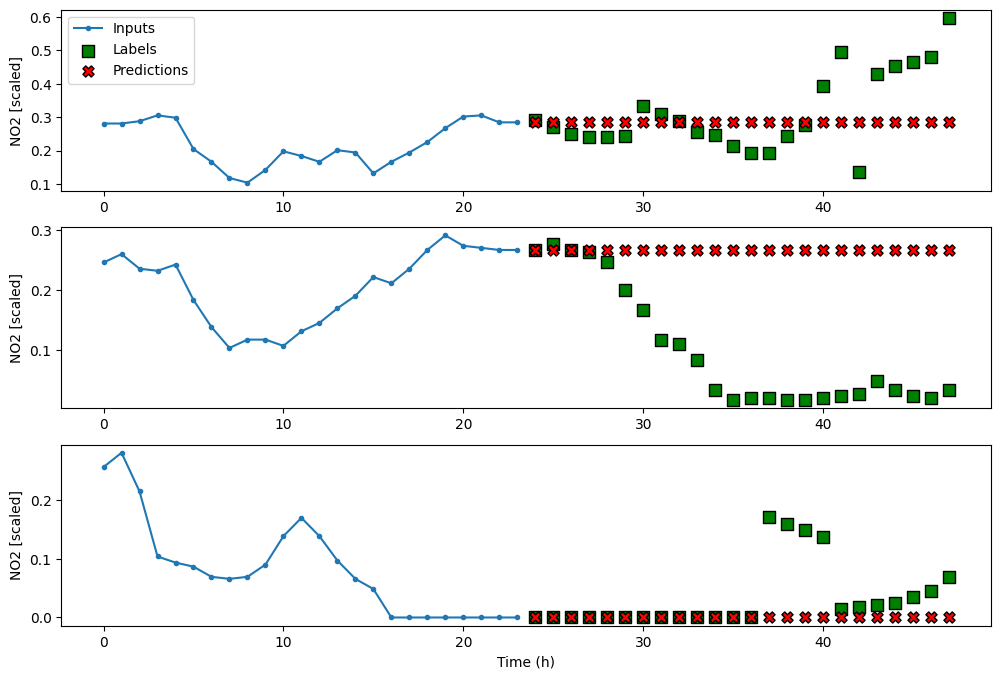

In [82]:
# 마지막으로 측정된 값으로 예측하기
multi_window.plot(ms_baseline_last)

In [83]:
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['NO2'])

ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)
ms_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0)

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1418 - mean_absolute_error: 0.2817


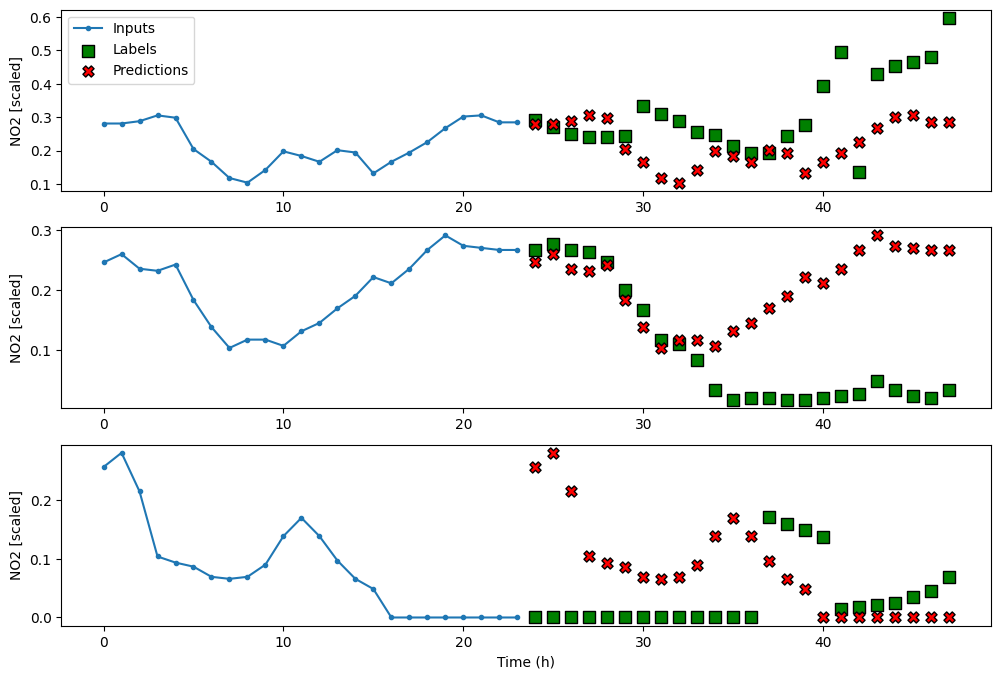

In [84]:
# 입력 배열 반복하기
multi_window.plot(ms_baseline_repeat)

### d. MAE 사용하여 두 모델을 평가하고 성능 저장

In [85]:
print(ms_performance['Baseline - Last'][1])
print(ms_performance['Baseline - Repeat'][1])

ms_performance_last = ms_performance['Baseline - Last'][1]
ms_performance_repeat = ms_performance['Baseline - Repeat'][1]

0.24281959235668182
0.24616234004497528


## 3. 다중 출력 모델

### a. 마지막으로 측정된 값으로 예측하는 베이스라인 모델 구축

In [86]:
# 베이스라인 - 입력 데이터를 예측으로 반환하는 클래스
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs

        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)

        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

### b. 도식화

In [87]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['NO2','TEMP'])
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['NO2','TEMP'])


In [88]:
print(column_indices['NO2'])
print(column_indices['TEMP'])

3
6


In [89]:
mo_baseline_last = Baseline(label_index=[3, 6])

mo_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

mo_val_performance = {}
mo_performance = {}

mo_val_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.val)
mo_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.test, verbose=0)

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013 - mean_absolute_error: 0.0215


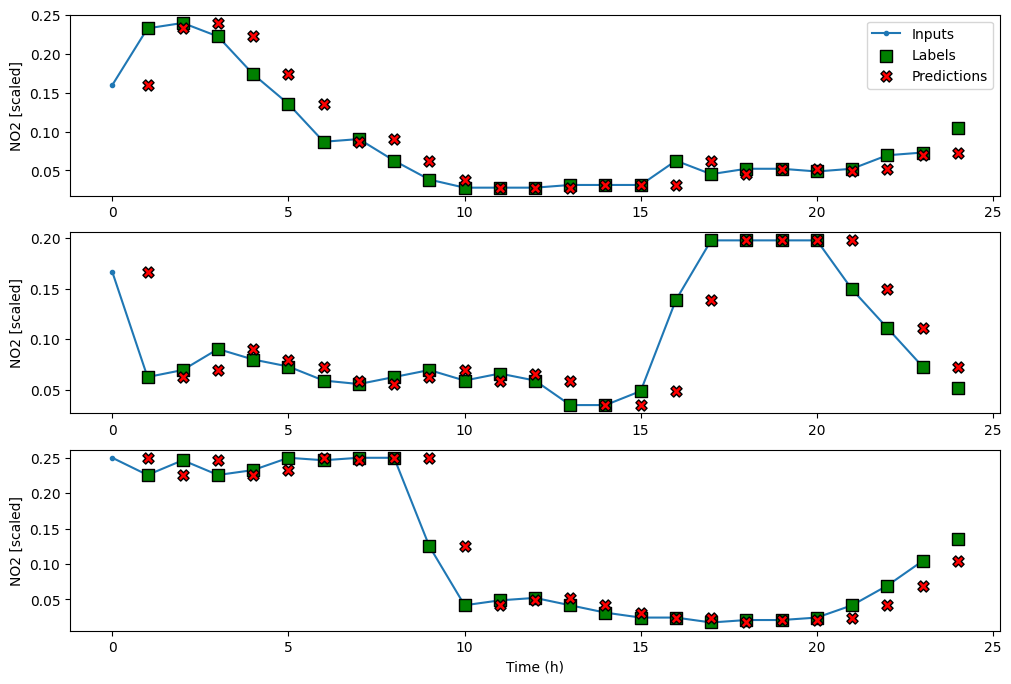

In [90]:
mo_wide_window.plot(mo_baseline_last)

### c. MAE를 사용하여 성능을 평가하고 비교할 수 있도록 사전에 저장

In [91]:
print(mo_performance['Baseline - Last'][1])

mo_performance_last = ms_performance['Baseline - Last'][1]

0.024792805314064026


# 14.4 연습


##1. 단일 단계 모델

### a. 선형 모델 구축

In [92]:
linear = Sequential([
    Dense(units=1)
])

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0314 - mean_absolute_error: 0.1379 - val_loss: 0.0055 - val_mean_absolute_error: 0.0589
Epoch 2/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0051 - mean_absolute_error: 0.0510 - val_loss: 0.0026 - val_mean_absolute_error: 0.0365
Epoch 3/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0033 - mean_absolute_error: 0.0382 - val_loss: 0.0022 - val_mean_absolute_error: 0.0313
Epoch 4/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0026 - mean_absolute_error: 0.0338 - val_loss: 0.0020 - val_mean_absolute_error: 0.0295
Epoch 5/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0022 - mean_absolute_error: 0.0313 - val_loss: 0.0020 - val_mean_absolute_error: 0.0299
Epoch 6/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0020 - mean_absolute_error: 0.0298 - val_loss: 0.0020 - val_mean_absolute_error: 0.0285
Epoch 7/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0019 - mean_absolute_error: 0.0287 - v

### b. 예측 도식화

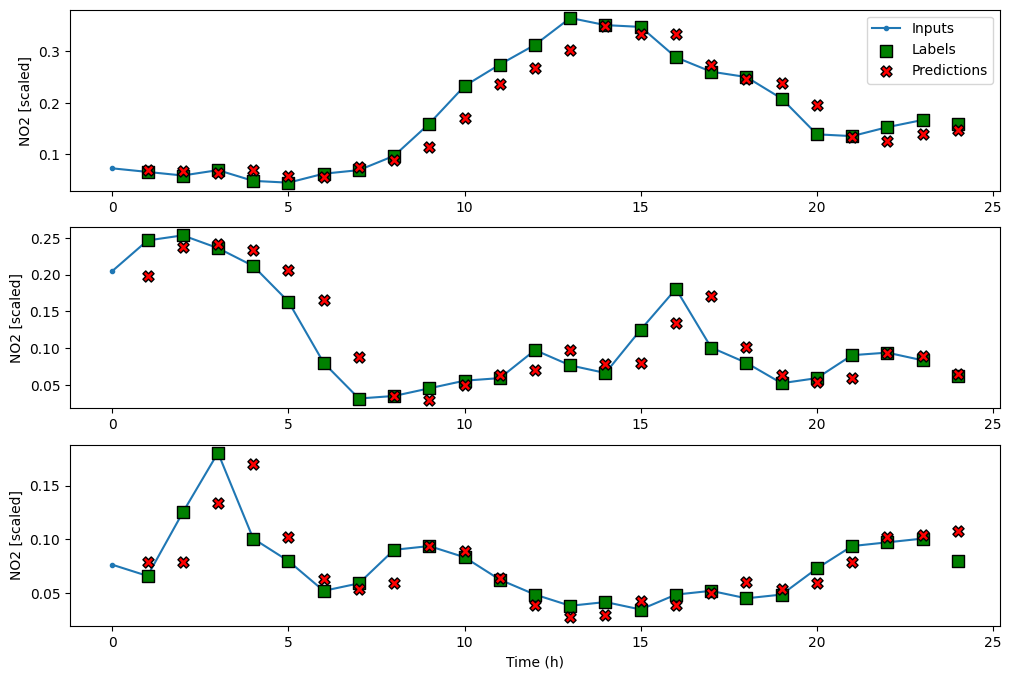

In [93]:
wide_window.plot(linear)

### c. 평균 절대 오차로 성능 측정하고 저장

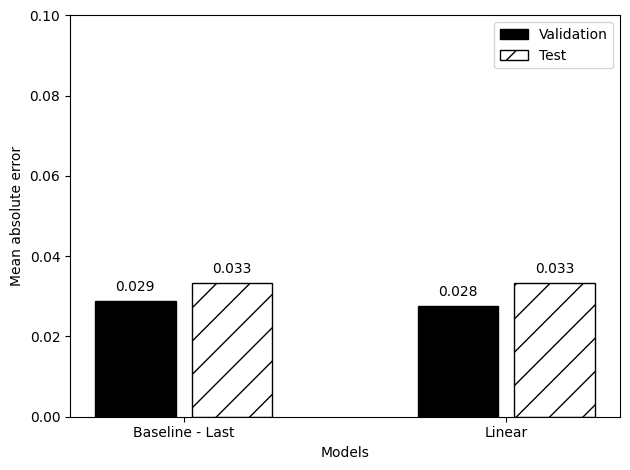

In [99]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

### d. 심층 신경망 구축

In [100]:
dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0085 - mean_absolute_error: 0.0577 - val_loss: 0.0020 - val_mean_absolute_error: 0.0285
Epoch 2/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0017 - mean_absolute_error: 0.0277 - val_loss: 0.0020 - val_mean_absolute_error: 0.0287
Epoch 3/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0017 - mean_absolute_error: 0.0275 - val_loss: 0.0020 - val_mean_absolute_error: 0.0290
Epoch 4/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0016 - mean_absolute_error: 0.0270 - val_loss: 0.0020 - val_mean_absolute_error: 0.0295
Epoch 5/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0016 - mean_absolute_error: 0.0268 - val_loss: 0.0019 - val_mean_absolute_error: 0.0278
Epoch 6/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0016 - mean_absolute_error: 0.0264 - val_loss: 0.0021 - val_mean_absolute_error: 0.0307
Epoch 7/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0016 - mean_absolute_error: 0.0265 - v

###  e. 예측 결과 도식화

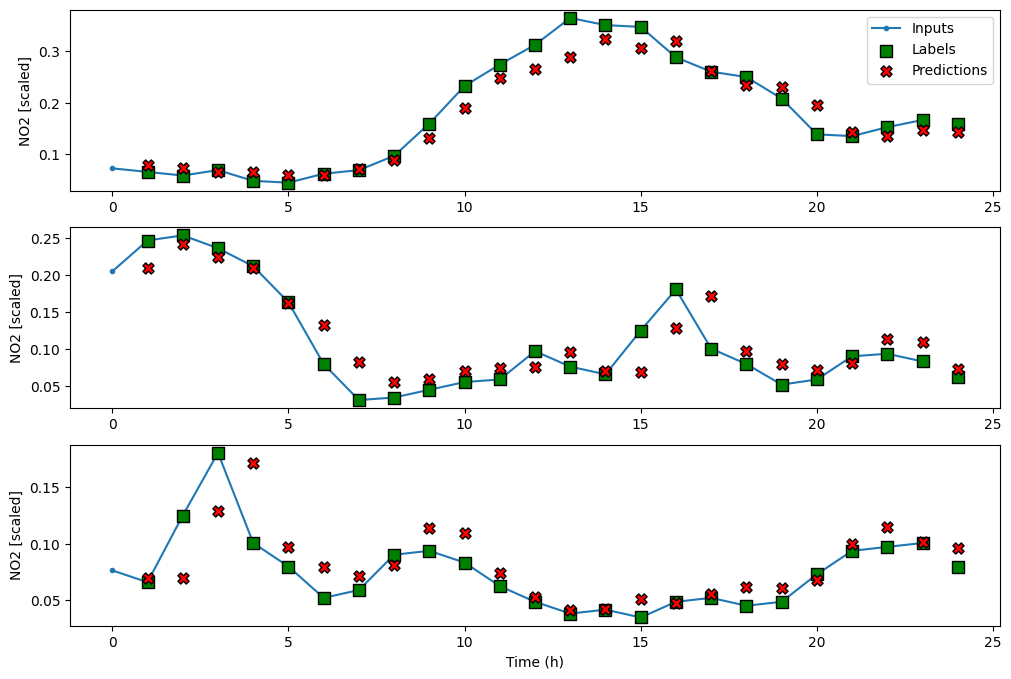

In [101]:
wide_window.plot(dense)

### f. MAE로 성능 측정하고 저장

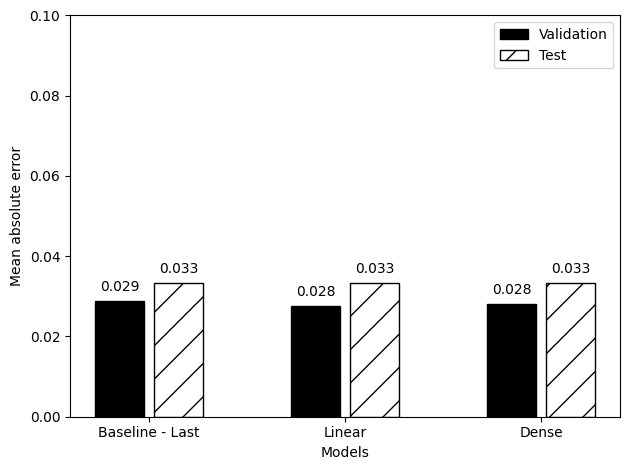

In [102]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

### g. 어느 모델이 가장 성능이 좋은가?

##2. 다중 단계 모델

### a. 선형 모델 구축

In [103]:
label_index = column_indices['NO2']
num_features = train_df.shape[1]

ms_linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(ms_linear, multi_window)

ms_val_performance['Linear'] = ms_linear.evaluate(multi_window.val)
ms_performance['Linear'] = ms_linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0199 - mean_absolute_error: 0.1050 - val_loss: 0.0096 - val_mean_absolute_error: 0.0742
Epoch 2/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0126 - mean_absolute_error: 0.0858 - val_loss: 0.0091 - val_mean_absolute_error: 0.0721
Epoch 3/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0122 - mean_absolute_error: 0.0846 - val_loss: 0.0089 - val_mean_absolute_error: 0.0719
Epoch 4/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0120 - mean_absolute_error: 0.0838 - val_loss: 0.0088 - val_mean_absolute_error: 0.0711
Epoch 5/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0119 - mean_absolute_error: 0.0833 - val_loss: 0.0087 - val_mean_absolute_error: 0.0712
Epoch 6/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0118 - mean_absolute_error: 0.0830 - val_loss: 0.0087 - val_mean_absolute_error: 0.0705
Epoch 7/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0118 - mean_absolute_error: 0.0826 - v

### b. 예측 도식화

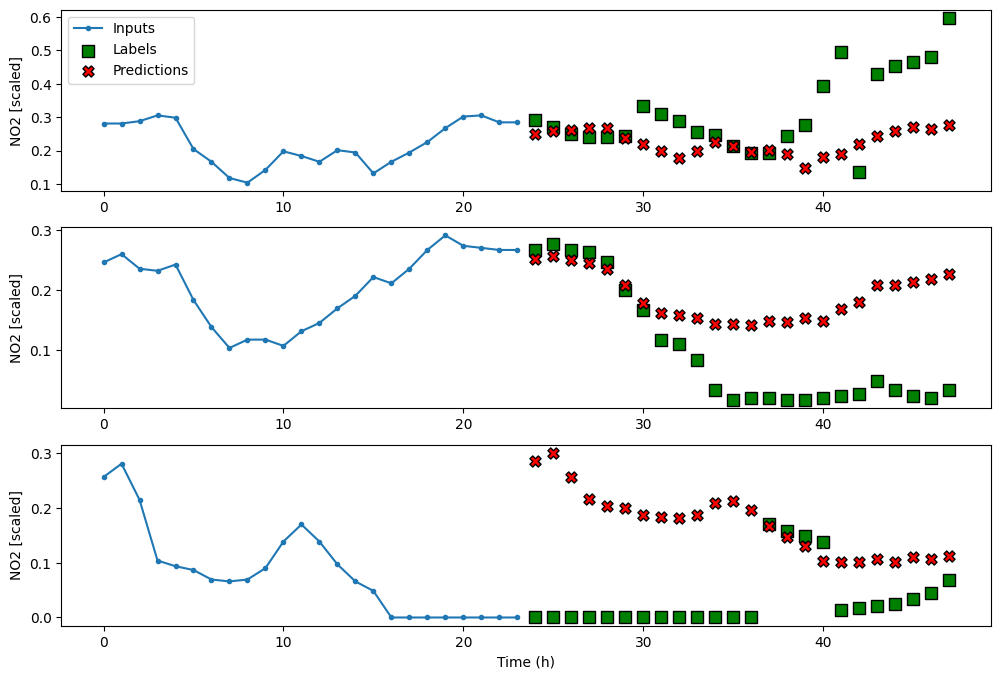

In [104]:
multi_window.plot(ms_linear)

### c. 평균 절대 오차로 성능 측정하고 저장

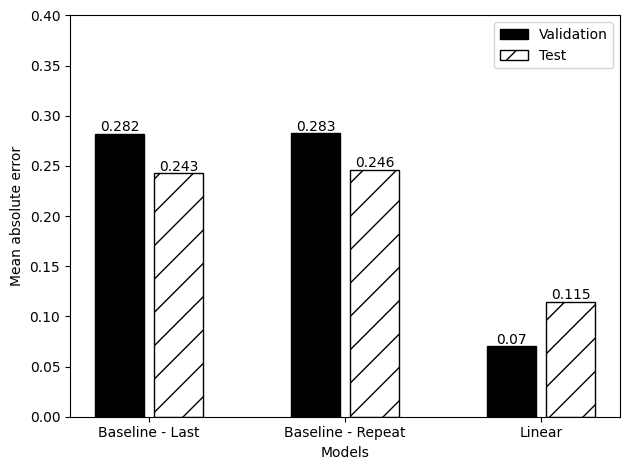

In [105]:
ms_mae_val = [v[1] for v in ms_val_performance.values()]
ms_mae_test = [v[1] for v in ms_performance.values()]

x = np.arange(len(ms_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=ms_performance.keys())
plt.legend(loc='best')
plt.tight_layout()


### d. 심층 신경망 구축

In [108]:
ms_dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_dense, multi_window)

ms_val_performance['Dense'] = ms_dense.evaluate(multi_window.val)
ms_performance['Dense'] = ms_dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0158 - mean_absolute_error: 0.0942 - val_loss: 0.0084 - val_mean_absolute_error: 0.0682
Epoch 2/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0111 - mean_absolute_error: 0.0796 - val_loss: 0.0085 - val_mean_absolute_error: 0.0692
Epoch 3/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0108 - mean_absolute_error: 0.0783 - val_loss: 0.0088 - val_mean_absolute_error: 0.0692
Epoch 4/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0106 - mean_absolute_error: 0.0775 - val_loss: 0.0090 - val_mean_absolute_error: 0.0697
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0088 - mean_absolute_error: 0.0693


###  e. 예측 결과 도식화

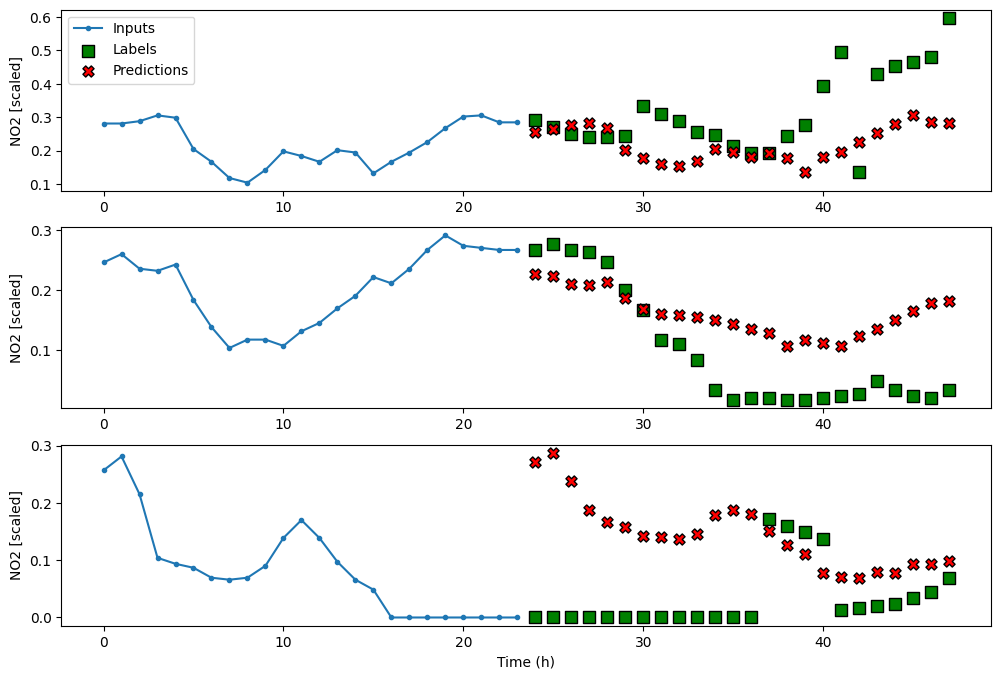

In [109]:
multi_window.plot(ms_dense)

### f. MAE로 성능 측정하고 저장

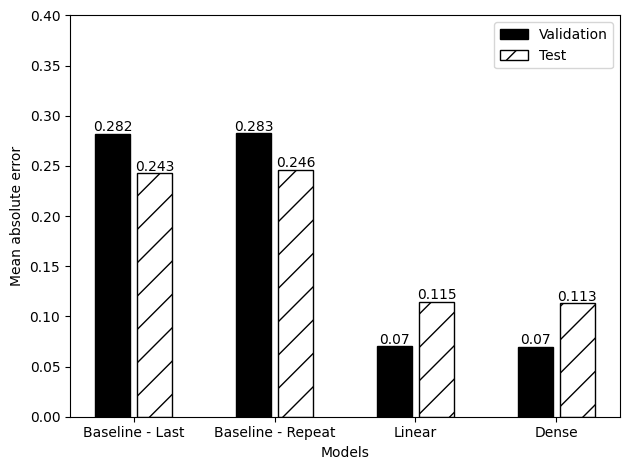

In [110]:
ms_mae_val = [v[1] for v in ms_val_performance.values()]
ms_mae_test = [v[1] for v in ms_performance.values()]

x = np.arange(len(ms_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=ms_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

### g. 어느 모델이 가장 성능이 좋은가?

##1. 다중 출력 모델

### a. 선형 모델 구축

In [111]:
mo_linear = Sequential([
    Dense(units=2)
])

history = compile_and_fit(mo_linear, mo_single_step_window)

mo_val_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.val)
mo_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0882 - mean_absolute_error: 0.2414 - val_loss: 0.0194 - val_mean_absolute_error: 0.1158
Epoch 2/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0164 - mean_absolute_error: 0.1033 - val_loss: 0.0056 - val_mean_absolute_error: 0.0601
Epoch 3/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0060 - mean_absolute_error: 0.0602 - val_loss: 0.0028 - val_mean_absolute_error: 0.0404
Epoch 4/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0037 - mean_absolute_error: 0.0463 - val_loss: 0.0022 - val_mean_absolute_error: 0.0343
Epoch 5/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0029 - mean_absolute_error: 0.0405 - val_loss: 0.0019 - val_mean_absolute_error: 0.0314
Epoch 6/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0024 - mean_absolute_error: 0.0365 - val_loss: 0.0016 - val_mean_absolute_error: 0.0289
Epoch 7/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0020 - mean_absolute_error: 0.0330 - v

### b. 예측 도식화

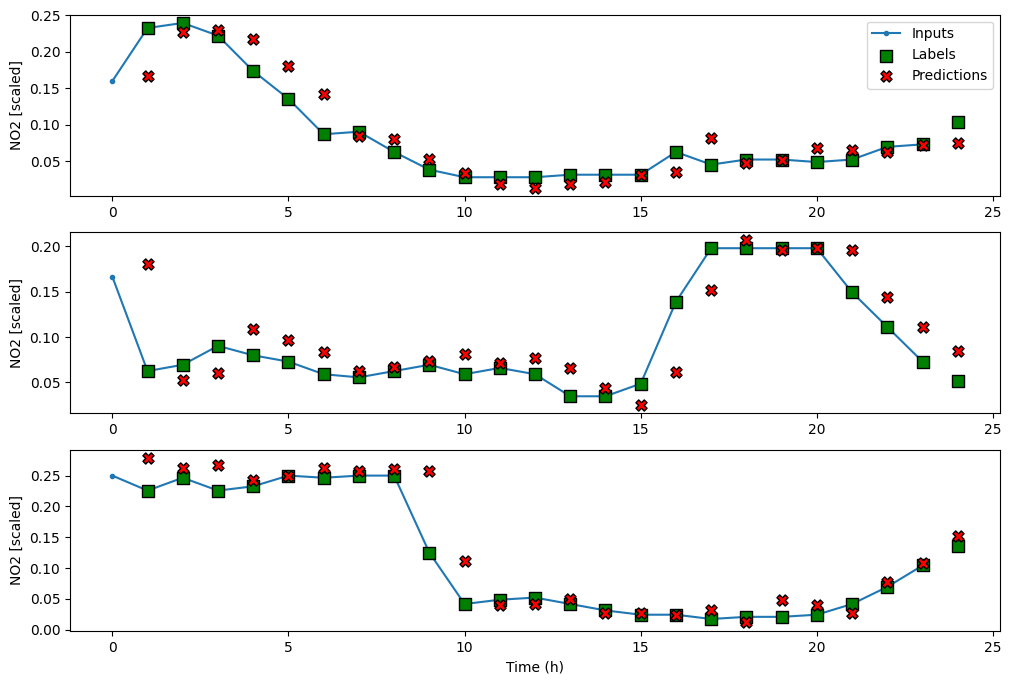

In [112]:
mo_wide_window.plot(mo_linear)

### c. 평균 절대 오차로 성능 측정하고 저장

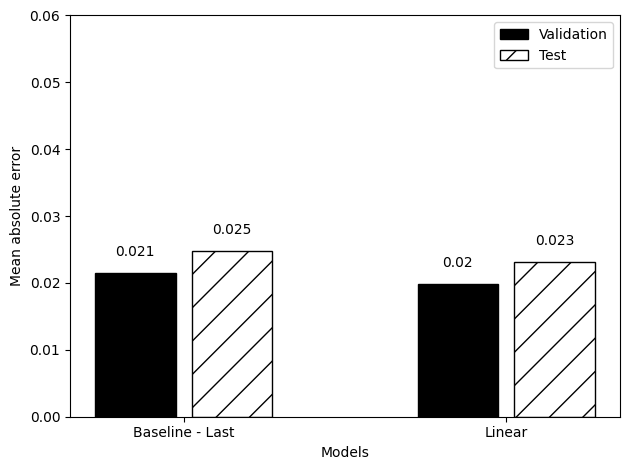

In [113]:
mo_mae_val = [v[1] for v in mo_val_performance.values()]
mo_mae_test = [v[1] for v in mo_performance.values()]

x = np.arange(len(mo_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=mo_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

### d. 심층 신경망 구축

In [114]:
mo_dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=2)
])

history = compile_and_fit(mo_dense, mo_single_step_window)

mo_val_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.val)
mo_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0173 - mean_absolute_error: 0.0764 - val_loss: 0.0013 - val_mean_absolute_error: 0.0227
Epoch 2/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0011 - mean_absolute_error: 0.0216 - val_loss: 0.0013 - val_mean_absolute_error: 0.0237
Epoch 3/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0010 - mean_absolute_error: 0.0206 - val_loss: 0.0011 - val_mean_absolute_error: 0.0202
Epoch 4/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.5634e-04 - mean_absolute_error: 0.0197 - val_loss: 0.0011 - val_mean_absolute_error: 0.0201
Epoch 5/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.7707e-04 - mean_absolute_error: 0.0202 - val_loss: 0.0011 - val_mean_absolute_error: 0.0199
Epoch 6/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.6680e-04 - mean_absolute_error: 0.0200 - val_loss: 0.0012 - val_mean_absolute_error: 0.0222
Epoch 7/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.6328e-04 - mean_absolute_e

###  e. 예측 결과 도식화

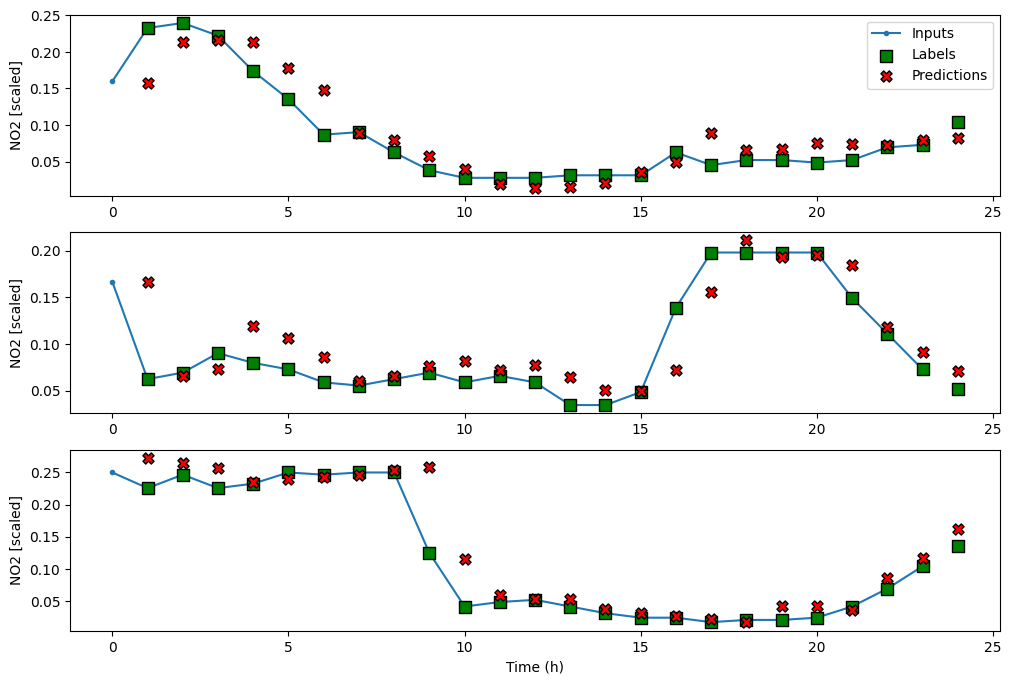

In [115]:
mo_wide_window.plot(mo_dense)

### f. MAE로 성능 측정하고 저장

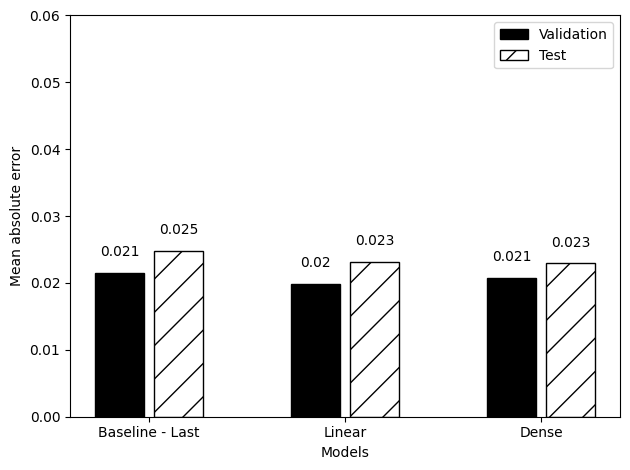

In [117]:
mo_mae_val = [v[1] for v in mo_val_performance.values()]
mo_mae_test = [v[1] for v in mo_performance.values()]

x = np.arange(len(mo_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=mo_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

### g. 어느 모델이 가장 성능이 좋은가?